In [11]:
import sys

import pandas as pd

sys.path.append('scripts/')
import flag_dimensionality_reduction as fdr
from utils import *

sys.path.append('Hands/')
from hand_utils import *

import numpy as np
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt


from geomstats.geometry.pre_shape import PreShapeSpace


class GeomstatsShapeSpace():
    """A simple adapter class which uses pymanopt language for geomstats shape space
    """

    def __init__(self, n, k):
        self._man = PreShapeSpace(m_ambient = n, k_landmarks = k)
        self._man.equip_with_group_action("rotations")
        self._man.equip_with_quotient_structure()

    def dist(self, point_a, point_b):
        return self._man.metric.dist(point_a, point_b)

    def exp(self, base_point, tangent_vector):
        return self._man.metric.exp(tangent_vector, base_point=base_point)

    def log(self, base_point, ambient_point):
        return self._man.to_tangent(ambient_point, base_point=base_point)
    
    def random_point(self):
        return self._man.random_point()


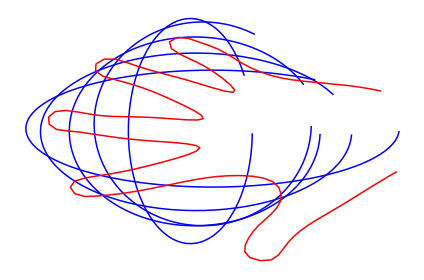

In [12]:
filepath = './Hands/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T


shapes = []
for h in hands:
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    shapes.append(k_shape)


def generate_ellipse_outlier1(seed: int):
    # np.random.seed(seed)

    # # Generate data points on the ellipse
    # x = np.random.normal(0,10, 56)
    # y = np.random.normal(0,10, 56) 

    
    # pt = np.vstack([x,y]).T

    # pt = pt - np.mean(pt, axis = 0)
    # pt = pt/np.linalg.norm(pt)
    # return pt
    np.random.seed(seed)
    # Define ellipse parameters
    center_x = .1*np.random.normal(0,1)  # X-coordinate of the center #was .1
    center_y = .1*np.random.normal(0,1)  # Y-coordinate of the center #was .1
    major_axis = .4+ np.random.normal(0,.1)#np.random.normal(0,.3) # np.random.normal(0,1)  # Length of the major axis
    minor_axis = .4+ np.random.normal(0,.1)#np.random.normal(0,.3)  #np.random.normal(0,1)   # Length of the minor axis


    # Generate data points on the ellipse
    # theta = np.linspace(-0.2, 1.8*np.pi, 56)  # Create 100 equally spaced points around the ellipse
    theta = np.linspace(.1 + np.random.rand(),2*np.pi, 56)
    x = center_x + major_axis * np.cos(theta)
    y = center_y + minor_axis * np.sin(theta)
    
    pt = np.vstack([x,y]).T

    pt = pt - np.mean(pt, axis = 0)
    pt = pt/np.linalg.norm(pt)
    return pt

for i in range(5):
    outlier = generate_ellipse_outlier1(i)
    interp_points = interp(outlier)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'b')
interp_points = interp(shapes[0])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")

plt.tight_layout()

In [13]:
dr_seed = 12345

manifold = GeomstatsShapeSpace(2,56)


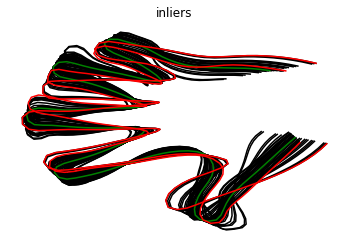

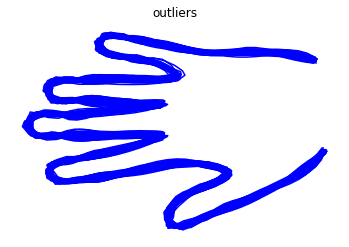

In [14]:

np.random.seed(1)

results = pd.DataFrame(columns = ['Num. Outliers','Algorithm', 'AUC'])
fl_type = [1,2]

#33 min to run

trial = 0

n_outs = 200

# load data
filepath = './Hands/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands0 = np.array(segmentationlist).T
hands = procrustes_hand(hands0)

hands1 = []
for h in hands:
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    hands1.append(k_shape)


x = hands1[0]
# ys = [hands1[7],hands1[9]]
# ys = [hands1[9],hands1[10]]
ys = [hands1[7],hands1[9]] #works with 7

shapes = []
for i in np.linspace(-1,1,40):
    idx = np.random.choice([0,1])
    v = manifold.log(x,ys[idx])
    inlier = manifold.exp(x, i*v)
    shapes.append(inlier)

plt.figure()
plt.title('inliers')
for z in shapes:
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'k')


interp_points = interp(x)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'g')
interp_points = interp(ys[0])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
interp_points = interp(ys[1])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")

# np.random.seed(123)
# x = generate_ellipse_outlier1(0)
for i in range(n_outs):
    # x= unmake_1d(hands[np.random.choice(np.arange(11,40,8))])
    x= unmake_1d(hands[35])
    x = x - np.mean(x, axis = 0)
    x = x/np.linalg.norm(x)
    y = manifold.random_point()
    v = manifold.log(x,y)
    outlier = manifold.exp(x, .05*np.random.rand()*v) #.05
    shapes.append(outlier)
# y = manifold.random_point()
# v = manifold.log(x,y)
# z = manifold.exp(x,.05*v)
# for i in range(n_outs):
#     y1 = manifold.random_point()
#     v1 = manifold.log(z,y1)
#     # x= unmake_1d(hands[np.random.choice(np.arange(11,40,8))])
#     outlier = manifold.exp(z, .1*(.5-np.random.rand()*v1)) #.05
#     shapes.append(outlier)
labels = [0]*40 + [1]*n_outs

# for h in hands0[11:]:
#     k_shape = unmake_1d(h)
#     k_shape = k_shape - np.mean(k_shape, axis = 0)
#     k_shape = k_shape/np.linalg.norm(k_shape)
#     shapes.append(k_shape)
# labels = [0]*40 + [1]*len(hands0[11:])



plt.figure()
plt.title('outliers')
# for z in shapes[-n_outs:]:
for z in shapes[40:]:
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'b')
    plt.axis("off")


--------------------
iteration 0
objective 0.0005645006033006395
flag distance between B0 and B1 0.4756781145428738

--------------------
iteration 1
objective 0.0005645006033006395
flag distance between B0 and B1 0.0



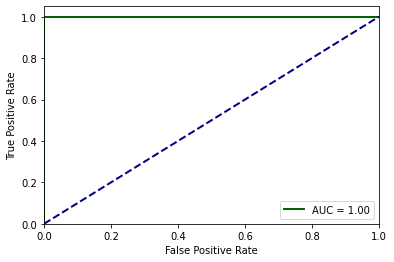

--------------------
iteration 0
objective 0.0026544556936204063
flag distance between B0 and B1 0.8146508728476083

--------------------
iteration 1
objective 0.0026544556936204063
flag distance between B0 and B1 0.0



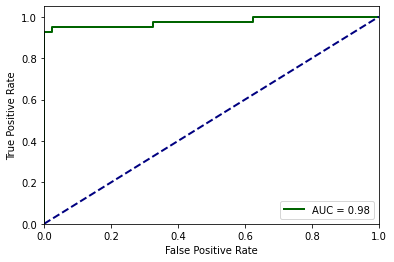

--------------------
iteration 0
objective 0.0020031272865030677
flag distance between B0 and B1 0.9947910629764517

--------------------
iteration 1
objective 0.0020031272865030677
flag distance between B0 and B1 2.5809568279517847e-08

--------------------
iteration 2
objective 0.0020031272865030677
flag distance between B0 and B1 2.5809568279517847e-08



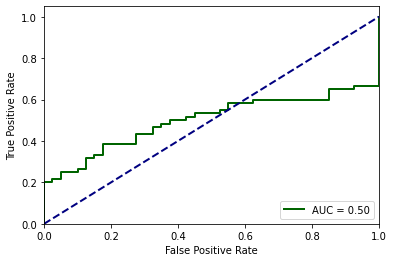

In [5]:
for n_shapes in [50,80,100]:#[60,80,100,120]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_d2ours,_,_], ts     = fdr.flag_robust_tpca(manifold, shapes[:n_shapes], 
                                                  fl_type = [fl_type[-1]], 
                                                  pca_type = 'dpcp', 
                                                  return_ts = True,
                                                  median = median, init = 'rand', 
                                                  rand_seed = dr_seed, verbose = True )

    auc_val, dpcp2_preds, dpcp2_thresh  = run_roc(shapes[:n_shapes], W_d2ours, labels[:n_shapes], 'dpcp', 
                                                  manifold, ts, median,do_plots = True )

--------------------
iteration 0
objective 0.0018638951020546841
flag distance between B0 and B1 0.45718781869198444

--------------------
iteration 1
objective 0.0018638951020546841
flag distance between B0 and B1 3.332000937312528e-08

--------------------
iteration 2
objective 0.0018638951020546841
flag distance between B0 and B1 3.332000937312528e-08



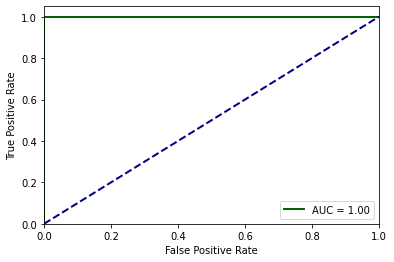

--------------------
iteration 0
objective 0.004525969407045845
flag distance between B0 and B1 0.7953752803097257

--------------------
iteration 1
objective 0.004525969407045845
flag distance between B0 and B1 5.960464477539063e-08

--------------------
iteration 2
objective 0.004525969407045845
flag distance between B0 and B1 5.960464477539063e-08



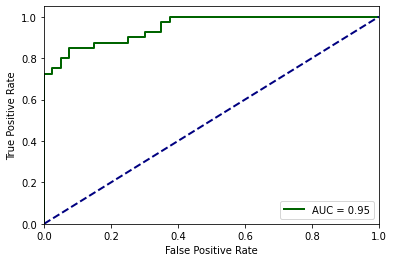

--------------------
iteration 0
objective 0.0028866757138726385
flag distance between B0 and B1 0.9991014088652644

--------------------
iteration 1
objective 0.0028866757138726385
flag distance between B0 and B1 3.650024149988857e-08

--------------------
iteration 2
objective 0.0028866757138726385
flag distance between B0 and B1 3.650024149988857e-08



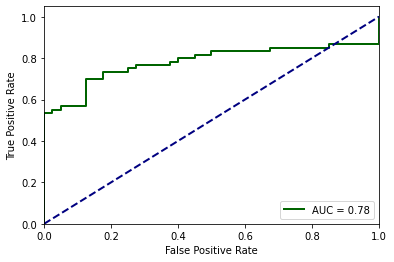

In [6]:
for n_shapes in [50,80,100]:#[60,80,100,120]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_d2ours,_,_], ts     = fdr.flag_robust_tpca(manifold, shapes[:n_shapes], 
                                                  fl_type = fl_type, 
                                                  pca_type = 'dpcp', 
                                                  return_ts = True,
                                                  median = median, init = 'rand', 
                                                  rand_seed = dr_seed, verbose = True )

    auc_val, dpcp2_preds, dpcp2_thresh  = run_roc(shapes[:n_shapes], W_d2ours, labels[:n_shapes], 'dpcp', 
                                                  manifold, ts, median,do_plots = True )

--------------------
iteration 0
objective 0.9405055702449584
flag distance between B0 and B1 1.4026641032227245

--------------------
iteration 1
objective 0.9179786212658123
flag distance between B0 and B1 0.033357638841035174

--------------------
iteration 2
objective 0.9056547354324508
flag distance between B0 and B1 0.02438647194409594

--------------------
iteration 3
objective 0.9014933637180984
flag distance between B0 and B1 0.012783223261504828

--------------------
iteration 4
objective 0.9003307739260544
flag distance between B0 and B1 0.006381089066908594

--------------------
iteration 5
objective 0.9003307739260544
flag distance between B0 and B1 0.0



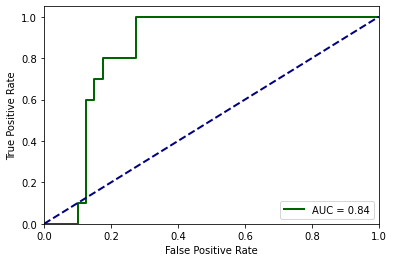

--------------------
iteration 0
objective 1.9478896408943334
flag distance between B0 and B1 1.3968676709081225

--------------------
iteration 1
objective 1.6538823515369008
flag distance between B0 and B1 0.27512740087802257

--------------------
iteration 2
objective 1.6172167709604792
flag distance between B0 and B1 0.02029558083539281

--------------------
iteration 3
objective 1.6074183340094954
flag distance between B0 and B1 0.009831827689449265

--------------------
iteration 4
objective 1.6074183340094954
flag distance between B0 and B1 0.0



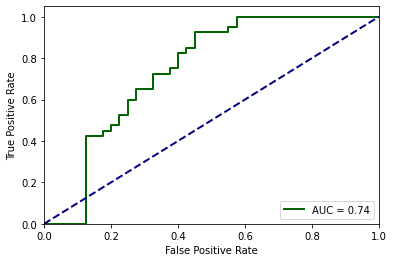

--------------------
iteration 0
objective 2.9615601269073495
flag distance between B0 and B1 1.3502577688215034

--------------------
iteration 1
objective 2.12485907033572
flag distance between B0 and B1 0.7881755499599926

--------------------
iteration 2
objective 2.031693167784958
flag distance between B0 and B1 0.09932015978744678

--------------------
iteration 3
objective 2.031693167784958
flag distance between B0 and B1 0.0



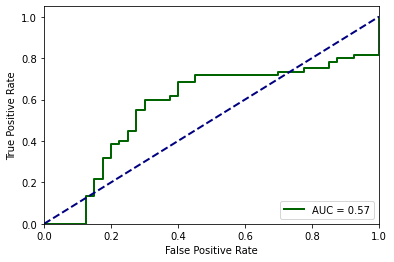

In [7]:
for n_shapes in [50,80,100]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_w2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes[:n_shapes], fl_type = [fl_type[-1]], pca_type = 'wpca', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = True )

    auc_val, wpca2_preds, wpca2_thresh  = run_roc( shapes[:n_shapes], W_w2ours, labels[:n_shapes], 'wpca', manifold, ts,     median,do_plots = True )


--------------------
iteration 0
objective 7.068309063909867
flag distance between B0 and B1 1.4028587586610761

--------------------
iteration 1
objective 7.068611738917336
flag distance between B0 and B1 0.024210561483483103

--------------------
iteration 2
objective 7.06861880608455
flag distance between B0 and B1 0.0037053940974590546

--------------------
iteration 3
objective 7.068618977527921
flag distance between B0 and B1 0.000578112517660121

--------------------
iteration 4
objective 7.068618977527921
flag distance between B0 and B1 0.0



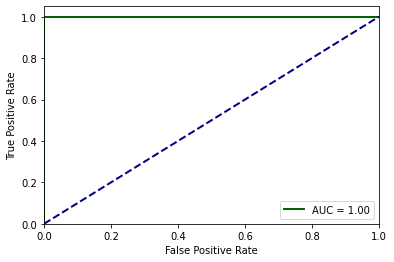

--------------------
iteration 0
objective 16.7115893295641
flag distance between B0 and B1 1.3972582505693456

--------------------
iteration 1
objective 16.725204946896138
flag distance between B0 and B1 0.3007926818734763

--------------------
iteration 2
objective 16.725910416788107
flag distance between B0 and B1 0.06197663709582464

--------------------
iteration 3
objective 16.72602130812395
flag distance between B0 and B1 0.02430165500260723

--------------------
iteration 4
objective 16.726039793690585
flag distance between B0 and B1 0.009919163942042635

--------------------
iteration 5
objective 16.72604286838881
flag distance between B0 and B1 0.0040454276829737104

--------------------
iteration 6
objective 16.72604337893963
flag distance between B0 and B1 0.0016482389705504165

--------------------
iteration 7
objective 16.72604337893963
flag distance between B0 and B1 0.0



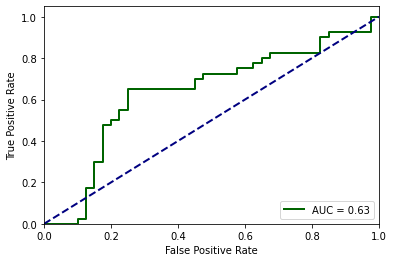

--------------------
iteration 0
objective 16.79935087355235
flag distance between B0 and B1 1.3557376383029485

--------------------
iteration 1
objective 16.826466758827248
flag distance between B0 and B1 0.44311220407614244

--------------------
iteration 2
objective 16.834844248615944
flag distance between B0 and B1 0.23069880493388828

--------------------
iteration 3
objective 16.837627653809147
flag distance between B0 and B1 0.12825292375856162

--------------------
iteration 4
objective 16.838734066313656
flag distance between B0 and B1 0.07752882538470197

--------------------
iteration 5
objective 16.839381592922127
flag distance between B0 and B1 0.05622179535910474

--------------------
iteration 6
objective 16.839963168266223
flag distance between B0 and B1 0.05069970873844285

--------------------
iteration 7
objective 16.8406704412996
flag distance between B0 and B1 0.05432537788583774

--------------------
iteration 8
objective 16.841595786467174
flag distance between 

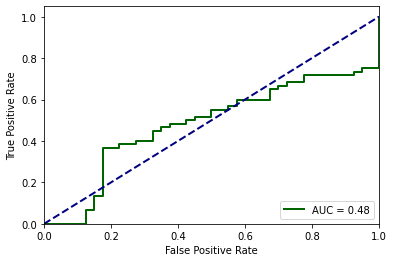

In [8]:
for n_shapes in [50,80,100]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_w2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes[:n_shapes], fl_type = [fl_type[-1]], pca_type = 'rpca', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = True )

    auc_val, wpca2_preds, wpca2_thresh  = run_roc( shapes[:n_shapes], W_w2ours, labels[:n_shapes], 'rpca', manifold, ts,     median,do_plots = True )


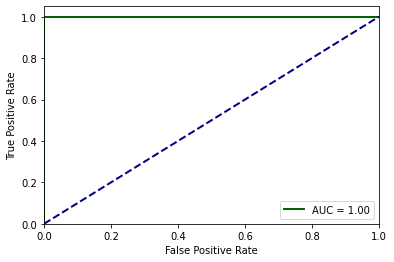

In [16]:
for n_shapes in [200]:
    W_pca, _, ts_pca, mean =   PGA0( manifold, shapes[:n_shapes], [fl_type[-1]], return_ts = True, eps = 1e-9 )

    auc_val, pca_preds, pca_thresh  = run_roc( shapes[:n_shapes], W_pca, labels[:n_shapes], 'pca', manifold, ts_pca, mean, do_plots = True )

(-38.600453450648104,
 43.339782412099076,
 -40.71519653575831,
 42.09806511035632)

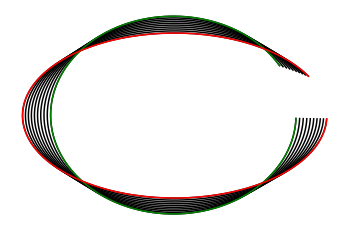

In [10]:

# x = shapes[0]
# y = shapes[7]

x = generate_ellipse_outlier1(0)
y = generate_ellipse_outlier1(1)
v = manifold.log(x,y)


for i in np.linspace(0,1,10):
    z = manifold.exp(x, i*v)
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'k')
    plt.axis("off")



interp_points = interp(x)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'g')
plt.axis("off")

interp_points = interp(y)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")